In [2]:
from torch.utils.data import Dataset
import torch
import os
from PIL import Image
import numpy as np
import torch.nn as nn
from torchvision import transforms,models
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import cv2
from torch.nn import functional as F
import torch.optim as optim

In [3]:
class SmileDataset(Dataset):
    def __init__(self, data_dir,transform=None):
        self.data_info = self.get_img_info(data_dir)  
        self.transform = transform

    def __getitem__(self, index):
        path_img, label = self.data_info[index]
        img = Image.open(path_img).convert('RGB')
        if self.transform is not None:
            img = transform(img)
        label = torch.tensor(np.array(label))
        return img, label

    def __len__(self):
        return len(self.data_info)

    def get_img_info(self,data_dir):
        data_info = []
        label_names=os.listdir(data_dir)
        for label in label_names:
            img_names = os.listdir(os.path.join(data_dir, label))
            #选取jpg结尾的图像
            img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))
            # 遍历图片
            for img_name in img_names:
                path_img = os.path.join(data_dir, label, img_name)
                data_info.append((path_img, label_names.index(label)))
        return data_info

In [4]:
# 数据的路径
split_dir = './pics_no_yes1/'
train_dir = os.path.join(split_dir, 'train/')
valid_dir = os.path.join(split_dir, 'val/')

# 定义图像增强流水线
transform = transforms.Compose([
    transforms.Resize((320,320)),
    # #Normalize
    # transform.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    # #在图片的中间区域进行裁剪
    # transforms.CenterCrop(10),
    transforms.ToTensor(),
])
BATCH_SIZE = 1
# 构建DataLoader
train_loader = DataLoader(SmileDataset(train_dir, transform), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(SmileDataset(valid_dir, transform), batch_size=BATCH_SIZE, shuffle=True)

device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
device

device(type='cuda')

torch.Size([8, 3, 320, 320]) torch.Size([8])


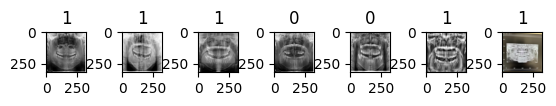

In [48]:
def convertimg(img,channel):
    if channel ==3:
        img = np.transpose(img.numpy(),(1,2,0))
    else:
        img = np.squeeze(img.numpy())
    return img

image,label = next(iter(train_loader))
print(image.shape,label.shape)
label = label.numpy()
for i in range(7):
    temp = i+1
    plt.subplot(1,7,temp)
    plt.imshow(convertimg(image[temp],3))
    plt.title(label[temp]) 
    plt.subplots_adjust(wspace=0.9, hspace=0.8)
plt.show()

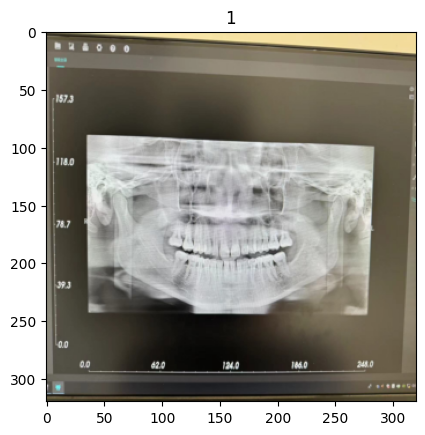

In [49]:
plt.imshow(convertimg(image[temp],3))
plt.title(label[temp]) 
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self, dim_q, dim_k, dim_v):
        super(SelfAttention, self).__init__()
        self.dim_q = dim_q
        self.dim_k = dim_k
        self.dim_v = dim_v
        self.linear_q = nn.Linear(dim_q, dim_k, bias=False)
        self.linear_k = nn.Linear(dim_q, dim_k, bias=False)
        self.linear_v = nn.Linear(dim_q, dim_v, bias=False)
        self._norm_fact = 1 / math.sqrt(dim_k)

    def forward(self, x):
        batch, n, dim_q = x.shape
        assert dim_q == self.dim_q
        
        q = self.linear_q(x)  
        k = self.linear_k(x)  
        v = self.linear_v(x)  
        
        dist = torch.bmm(q, k.transpose(1, 2)) * self._norm_fact
        dist = F.softmax(dist, dim=-1)  
        att = torch.bmm(dist, v)
        return att

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, attention=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
        self.attention = attention
        if self.attention:
            self.self_attention = SelfAttention(dim_q=planes, dim_k=planes, dim_v=planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        if self.attention:
            # Flatten the tensor for attention (batch_size, channels, height, width) -> (batch_size, height * width, channels)
            batch_size, channels, height, width = out.size()
            out_flat = out.view(batch_size, height * width, channels)
            out_flat = self.self_attention(out_flat)
            # Reshape back to (batch_size, channels, height, width)
            out = out_flat.view(batch_size, height, width, channels).permute(0, 3, 1, 2)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, attention_layer=None):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, attention_layer=attention_layer)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, attention_layer=attention_layer)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, attention_layer=attention_layer)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, attention_layer=attention_layer)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, attention_layer):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, attention=attention_layer))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(attention_layer=False):
    return ResNet(BasicBlock, [2, 2, 2, 2], attention_layer=attention_layer)

# Example usage
# net = ResNet18(attention_layer=True)
# y = net(torch.randn(1, 3, 32, 32))
# print(y.size())


In [22]:
# model = ResNet18(attention_layer=True)
# model = models.resnet34()
# model.fc=nn.Linear(in_features=512, out_features=2, bias=True)

import torch
import torch.nn as nn
import torchvision.models as models

# 加载预训练的 VGG16 模型
model = models.vgg16(pretrained=True)



# 1. 清空分类层
model.classifier = nn.Sequential()

# num_classes 为你的分类数
model.classifier = nn.Sequential(
    nn.Linear(25088, 2048),
    nn.ReLU(True),
    nn.Dropout(p=0.1),
    nn.Linear(2048, 1024),
    nn.ReLU(True),
    nn.Dropout(p=0.1),
    nn.Linear(1024, 2)
)


model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
# train
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# loss_fun = nn.BCELoss()


epoch_num = 200
for epoch in range(0, epoch_num):
    model.train()
    for inputs, labels in train_loader:
        # print(inputs,labels)
        # ite_num = ite_num + 1
        # ite_num4val = ite_num4val + 1
    
        # wrap them in Variable
        if torch.cuda.is_available():
            inputs_v, labels_v = inputs.to(device).float(), labels.to(device).long(),
        else:
            inputs_v, labels_v = inputs.float(), labels.long()
        # inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)
        # y zero the parameter gradients
        opt.zero_grad()
    
        # forward + backward + optimize
        outputs = model(inputs_v)
        # pred_classes = outputs.argmax(dim=1).float()
        loss = loss_fun(outputs, labels_v)
        print(loss)
        loss.backward()
        opt.step()
        
    

tensor(0.7529, device='cuda:0', grad_fn=<NllLossBackward>)


RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED
You can try to repro this exception using the following code snippet. If that doesn't trigger the error, please include your original repro script when reporting this issue.

import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
data = torch.randn([1, 512, 40, 40], dtype=torch.float, device='cuda', requires_grad=True)
net = torch.nn.Conv2d(512, 512, kernel_size=[3, 3], padding=[1, 1], stride=[1, 1], dilation=[1, 1], groups=1)
net = net.cuda().float()
out = net(data)
out.backward(torch.randn_like(out))
torch.cuda.synchronize()

ConvolutionParams 
    data_type = CUDNN_DATA_FLOAT
    padding = [1, 1, 0]
    stride = [1, 1, 0]
    dilation = [1, 1, 0]
    groups = 1
    deterministic = false
    allow_tf32 = true
input: TensorDescriptor 0x7fc6ec0df8e0
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 512, 40, 40, 
    strideA = 819200, 1600, 40, 1, 
output: TensorDescriptor 0x7fc6ec0df340
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 512, 40, 40, 
    strideA = 819200, 1600, 40, 1, 
weight: FilterDescriptor 0x7fc6ec0e38e0
    type = CUDNN_DATA_FLOAT
    tensor_format = CUDNN_TENSOR_NCHW
    nbDims = 4
    dimA = 512, 512, 3, 3, 
Pointer addresses: 
    input: 0x7fc684400000
    output: 0x7fc684d60000
    weight: 0x7fc685080000
Additional pointer addresses: 
    grad_output: 0x7fc684d60000
    grad_weight: 0x7fc685080000
Backward filter algorithm: 5


In [19]:
outputs,labels_v,loss

(tensor([[0.0791, 0.0317]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([0], device='cuda:0'),
 tensor(0.6697, device='cuda:0', grad_fn=<NllLossBackward>))

In [ ]:
# test
model.eval()
TestAcc = []
TestLoss = []
with torch.no_grad():
    for inputs, outputs in valid_loader:
        inputs, outputs = inputs.to(device).float(), outputs.to(device).long()
        # 计算损失
        pred = model(inputs)
        loss = loss_Function(pred,outputs)
        # softmax激活为概率分布
        pred = nn.functional.softmax(pred, dim=1)
        pred_classes = pred.argmax(dim=1)
        # 计算ACC
        train_acc = ((pred_classes == outputs).type(torch.float).sum().item())/ len(inputs)
        TestAcc.append(train_acc)
        TestLoss.append(loss)
avgTestLoss = torch.mean(torch.stack(TestLoss))
avgTestAcc = sum(TestAcc) / len(TestAcc)
print("testing loss is {:.5f},testing Acc is {:.5f}".format(avgTestLoss,avgTestAcc))

In [3]:
3000000*0.015/12

3750.0

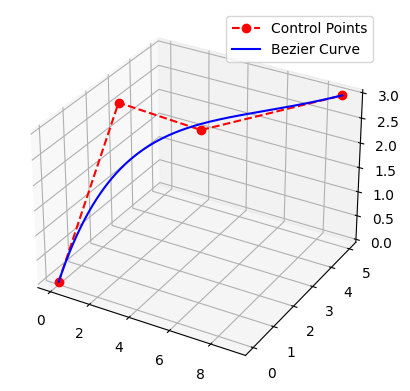

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def bezier_curve(control_points, num_points=1000):
    T = np.linspace(0, 1, num_points, dtype=np.float64)
    n = len(control_points) - 1
    curve = np.zeros((num_points, 3))
    for num, t in enumerate(T):
        point = control_points.copy()
        for i in range(n):
            for j in range(len(point) - 1):
                point[j] = (1 - t) * point[j] + t * point[j + 1]
            point = np.delete(point, len(point) - 1, axis=0)
        curve[num, :] = point
    return curve


# 控制点
points = np.array([[0, 0, 0], [1, 2, 3], [3, 4, 2], [9, 5, 3]], dtype=np.float64)

# 计算贝塞尔曲线
curve_points = bezier_curve(points)

# 绘制
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(points[:, 0], points[:, 1], points[:, 2], 'ro--', label='Control Points')
ax.plot(curve_points[:, 0], curve_points[:, 1], curve_points[:, 2], 'b-', label='Bezier Curve')
ax.legend()
plt.show()

